In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

In [2]:
import torch

In [3]:
from torchvision.datasets import ImageFolder

In [4]:
import torchvision.transforms as transforms

In [5]:
import torchvision

In [6]:
import time

In [7]:
import warnings
warnings.filterwarnings("ignore")

### Read the designation file

In [8]:
train = pd.read_csv('./dataset_v2/train.csv')
train.replace(' ', '_', regex=True,inplace=True)
train.replace('/', '_', regex=True,inplace=True)

In [9]:
#train.T

### Find the ground truth lists

In [10]:
# where
tag_id = train['tag_id']
image_id = train['image_id']
# features of 
general_class = train['general_class']
sub_class = train['sub_class']
color = train['color']

# features of numbers
sunroof = train['sunroof']
sunroof[sunroof<0]=0
luggage_carrier	 = train['luggage_carrier']
luggage_carrier[luggage_carrier<0]=0
open_cargo_area = train['open_cargo_area']
open_cargo_area[open_cargo_area<0]=0
enclosed_cab = train['enclosed_cab']
enclosed_cab[enclosed_cab<0]=0
spare_wheel = train['spare_wheel']
spare_wheel[spare_wheel<0]=0
wrecked = train['wrecked']
wrecked[wrecked<0]=0
flatbed = train['flatbed']
flatbed[flatbed<0]=0
ladder = train['ladder']
ladder[ladder<0]=0
enclosed_box = train['enclosed_box']
enclosed_box[enclosed_box<0]=0
soft_shell_box = train['soft_shell_box']
soft_shell_box[soft_shell_box<0]=0
harnessed_to_a_cart = train['harnessed_to_a_cart']
harnessed_to_a_cart[harnessed_to_a_cart<0]=0
ac_vents = train['ac_vents']
ac_vents[ac_vents<0]=0

### Define data loader and auxillary functions

In [11]:
import torch
from torchvision import datasets


'''reads the tag id from the end of path'''      
def get_id(path):
    return int(path[-9:-4])

'''# finds the index of the path id in the train file'''
def get_indx(id_):
    return [i for i, x in enumerate(tag_id==id_) if x][0]

'''returns hot encoded vectors'''
#
# General class 
#  [ small_vehicle , large_vehicle ]  x 2 categories
# 
# Color
#  [Yellow , Red , Blue , Black , Silver_Grey , White , Green , Other] x 8 categories
# sub class:
#  [ Sedan , Hatchback , Minivan , Van , Pickup truck , Jeep ,Truck , Prime mover, Light truck , 
#    Crane truck , Concrete mixer Truck , Dedicated agricultural , Minibus , Bus , Tanker] x 15 categories
# Features
#  [Sunroof , Luggage_carrier , Open cargo area , Enclosed cab , Wrecked , Spare wheel , AC vents , Enclosed box , 
#   Soft shell box , Ladder , Open cargo area , Harnessed to a cart , Flatbed] x 13 categorioes
#
#
def get_truth(id_):
    # get 
    class1 = np.array([int(general_class.iloc[id_]=='small_vehicle'),
                       int(general_class.iloc[id_]=='large_vehicle')])
    
    class2 = np.array([int(sub_class.iloc[id_]=='sedan'),
                      int(sub_class.iloc[id_]=='hatchback'),
                      int(sub_class.iloc[id_]=='minivan'),
                      int(sub_class.iloc[id_]=='van'),
                      int(sub_class.iloc[id_]=='pickup'),
                      int(sub_class.iloc[id_]=='jeep'),
                      int(sub_class.iloc[id_]=='truck'),
                      int(sub_class.iloc[id_]=='prime_mover'),
                      int(sub_class.iloc[id_]=='light_truck'),
                      int(sub_class.iloc[id_]=='crane_truck'),
                      int(sub_class.iloc[id_]=='concrete_mixer_truck'),
                      int(sub_class.iloc[id_]=='dedicated_agricultural_vehicle'),
                      int(sub_class.iloc[id_]=='minibus'),
                      int(sub_class.iloc[id_]=='bus'),
                      int(sub_class.iloc[id_]=='tanker')])
    
    features = np.array([sunroof.iloc[id_],
                         luggage_carrier.iloc[id_],
                         open_cargo_area.iloc[id_],
                         enclosed_cab.iloc[id_],
                         spare_wheel.iloc[id_],
                         wrecked.iloc[id_],
                         flatbed.iloc[id_],
                         ladder.iloc[id_],
                         enclosed_box.iloc[id_],
                         soft_shell_box.iloc[id_],
                         harnessed_to_a_cart.iloc[id_],
                         ac_vents.iloc[id_]])
    
    col = np.array([int(color.iloc[id_]=='yellow'),
                   int(color.iloc[id_]=='red'),
                   int(color.iloc[id_]=='blue'),
                   int(color.iloc[id_]=='black'),
                   int(color.iloc[id_]=='silver_grey'),
                   int(color.iloc[id_]=='white'),
                   int(color.iloc[id_]=='green'),
                   int(color.iloc[id_]=='other')])
    return class1 , class2 , col , features

def get_targets(paths):
    batch_size = len(paths)
    targets = np.zeros([batch_size,37])
    for i,path in enumerate(paths):
        id_ = get_id(path)
        indx = get_indx(id_)
        class1 , class2 , col , features = get_truth(indx)
        targets[i,0:2]=class1
        targets[i,2:17]=class2
        targets[i,17:25]=col
        targets[i,25:37]=features
    return torch.tensor(targets,dtype=torch.float)
        


In [12]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [13]:
# instantiate the dataset and dataloader
batch_size = 32

data_dir = './training imagery/class_2'
dataset = ImageFolderWithPaths(data_dir,transforms.Compose([transforms.Resize(224),
                                                            transforms.RandomRotation(359),
                                                            transforms.ToTensor()]))#,
                                                            #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            #std=[0.229, 0.224, 0.225])])) # our custom dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True,drop_last=True)

# iterate over data
for inputs, labels, paths in dataloader:
    # use the above variables freely
    #print(inputs, labels, paths)
    print(inputs.size())
    
    
    break

torch.Size([32, 3, 224, 224])


### Model

In [14]:
use_cuda = torch.cuda.is_available()
#use_cuda = False
def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

device = torch.device("cuda" if  torch.cuda.is_available() else "cpu")

use_cuda

True

In [15]:
from MobileNetV2 import MobileNetV2

mobnet50 = MobileNetV2(n_class=1000)
mobnet50.cuda()
state_dict = torch.load('mobilenet_v2.pth.tar') # add map_location='cpu' if no gpu
mobnet50.load_state_dict(state_dict)

In [16]:
import torch.nn as nn
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
                
        self.l1 = nn.Linear(in_features=1000, 
                            out_features=37,
                            bias=True)
        
        self.dropout = nn.Dropout(p=0.5) 
        
       
    def forward(self,x):
        x = self.l1(x)
        x = self.dropout(x)
        out = sigmoid(x)
        return out
    
net = Net()
if use_cuda:
    net.cuda()
    #model_conv.cuda()
print(net)

Net(
  (l1): Linear(in_features=1000, out_features=37, bias=True)
  (dropout): Dropout(p=0.5)
)


In [17]:
mobnet50

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace)
        (3): Conv2d(96

### Optimizer

In [18]:
#criterion = nn.BCEWithLogitsLoss(size_average='True')
params = list(net.parameters()) + list(mobnet50.parameters())
optimizer = torch.optim.SGD(params, lr = 0.01, momentum=0.9)

### Criterion

In [19]:
def criterion(prob,target):
    
    #accp = torch.log(prob*target+1e-2)
    accp = prob*target
    accp = accp.sum()/target.sum()
    
    #accn = torch.log(prob*(1-target)+1e-2)
    accn = prob*(1-target)
    accn = accn.sum()/(1-target).sum()
    
    return -accp+accn

In [20]:
device

device(type='cuda')

In [21]:
''' TEST WITH A SINGLE PASS'''
for inputs, labels, paths in dataloader:
    optimizer.zero_grad()
    
    inputs = get_variable(inputs)
    print(inputs.shape)
    inputs.to(device)
    
    mobout = mobnet50(inputs)
    
    out = net(mobout)
    
    targets = get_targets(paths).to(device)
        
    loss = criterion(out,targets)
    print(loss)
    loss.backward()
    optimizer.step()
    
    #out = out.reshape(batch_size,2048,7,7)
    print(out.shape)
    print(targets.shape)
    
    break

torch.Size([32, 3, 224, 224])
tensor(0.0515, device='cuda:0', grad_fn=<ThAddBackward>)
torch.Size([32, 37])
torch.Size([32, 37])


### Average positive accuracy and negative accuracy

In [22]:
def avg_pos_acc(prob,target):
    if np.sum(target)>0:
        acc = np.sum(prob*target)/np.sum(target)
    else:
        acc = 0
    return acc

def avg_neg_acc(prob,target):
    if np.sum(target)>0:
        acc = np.sum(prob*(target-1))/np.sum((target-1))
    else:
        acc = 0
    return acc

def class_acc(prob,target):
    classes = np.array(['Small vehicle',
              'Large vehicle',
              'Sedan',
              'Hatchback',
              'Minivan',
              'Van',
              'Pickup',
              'Jeep',
              'Truck',
              'Prime mover',
              'Light truck',
              'Crane truck',
              'Concrete mixer truck',
              'Dedicated agricultural vehice',
              'Minibus',
              'Bus',
              'Tanker',
              'Yellow',
              'Red',
              'Blue',
              'Black',
              'Silve grey',
              'White',
              'Green',
              'Other'
              'Sunroof',
              'Open cargo area',
              'Enclosed cab',
              'Spare weel',
              'Wrecked',
              'Flatbed',
              'Ladder',
              'Enclosed box',
              'Soft shell',
              'Harnessed to a cart',
              'Ac vents'])
    
    classes_pos_acc = np.zeros(np.size(classes))
    classes_neg_acc = np.zeros(np.size(classes))
    for i, class_ in enumerate(classes):
        classes_pos_acc[i] = avg_pos_acc(prob[:,i],target[:,i])
        classes_neg_acc[i] = avg_neg_acc(prob[:,i],target[:,i])
    return classes_pos_acc, classes_neg_acc, classes
        
        

In [23]:
from IPython.display import clear_output

In [24]:
def live_plot(data1,data2,classes,class_pos,class_neg, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    
    plt.plot(data1, label='Average correctly assigned probability')
    plt.plot(data2, label='Average wrongly assigned probability')
    plt.title(title)
    plt.grid(True)
    plt.xlabel('10\'th Batch')
    plt.legend(loc='top left') # the plot evolves to the right
    plt.ylim([0,1])
    
    plt.figure(figsize=figsize)
    
    plt.plot(class_pos, label='Average correctly assigned probability',marker='o',markersize=7,linewidth=0)
    plt.plot(class_neg, label='Average wrongly assigned probability',marker='x',markersize=7,linewidth=0)
    x_ticks=classes
    plt.xticks(np.arange(np.size(x_ticks)),x_ticks)
    plt.xticks(rotation=90)
    plt.legend(loc='top left') # the plot evolves to the right
    plt.ylim([0,1])
    plt.show();

### Training function

In [25]:
def train_model(criterion, optimizer, num_epochs=25):
    #best_model_wts = copy.deepcopy(model.state_dict())
    #best_acc = 0.0
    running_loss = np.array([])
    pos_acc = np.array([])
    neg_acc = np.array([])
    #ax2.plt.plot(running_loss, label='loss')
                #ax2.xlabel('Batch')
                #ax2.ylabel('Loss')
                
                #plt.figure.canvas.draw()
    
    
    for epoch in range(num_epochs):
        #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #print('-' * 10)
        
        # Each epoch has a training and validation phase
        
            #model_conv.train()
            
            # Iterate over data.
            for i,(inputs, labels, paths) in enumerate(dataloader):
                ############ SET TRAIN #################
                optimizer.zero_grad()
                net.train()
                mobnet50.train()
                ########### INPUTS #####################
                inputs = get_variable(inputs)
                inputs.to(device)
                ########## FORWARD #####################
                mobout = mobnet50(inputs)
                out = net(mobout)
                ########## GET TARGETS #################
                targets = get_targets(paths).to(device)
                ########## BACKWARD ####################
                loss = criterion(out,targets)
                loss.backward()
                ########## STEP ########################
                optimizer.step()
                ######### STATISTICS ###################
                if i%10==0:
                    net.eval()
                    mobnet50.eval()
                    ########## FORWARD #####################
                    mobout = mobnet50(inputs)
                    out = net(mobout)
                    ######### EVALUATE #####################
                    running_loss = np.append( running_loss, get_numpy(loss) )
                    pos_acc = np.append( pos_acc, avg_pos_acc( get_numpy(out), get_numpy(targets) ) )
                    neg_acc = np.append( neg_acc, avg_neg_acc( get_numpy(out), get_numpy(targets) ) )
                    classes_pos_acc, classes_neg_acc, classes = class_acc(get_numpy(out), get_numpy(targets))
                    ######## PLOT ##########################
                    live_plot(pos_acc,neg_acc,classes,classes_pos_acc,classes_neg_acc)
                
                
                
                
                
            #print('{} Loss: {:.4f} '.format(
            #        phase, epoch_loss/i))
            #time_elapsed = time.time() - since
            #print('Epoch complete in {:.0f}m {:.0f}s'.format(
            #        time_elapsed // 60, time_elapsed % 60))
            
        #print()
        
    return 

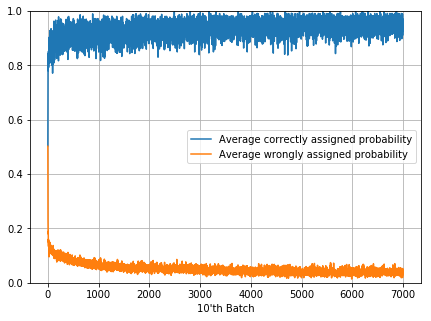

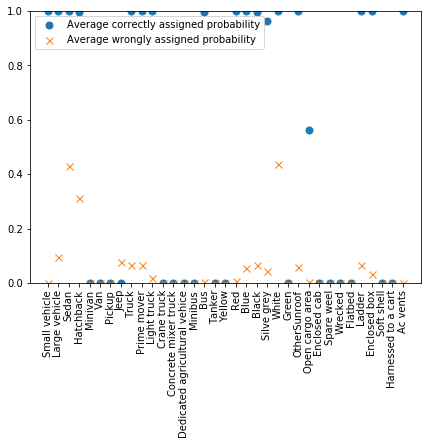

In [26]:
train_model(criterion,optimizer,num_epochs=100)

### Test the network

In [27]:
def test_model():
    #best_model_wts = copy.deepcopy(model.state_dict())
    #best_acc = 0.0
    running_loss = np.array([])
    
    net.eval()
    mobnet50.eval()
    # Iterate over data.
    target_list = np.array([])
    out_list = np.array([])
    for i,(inputs, labels, paths) in enumerate(dataloader):
        inputs = get_variable(inputs)
        inputs.to(device)
        ########## FORWARD #####################
        mobout = mobnet50(inputs)
        out = net(mobout)
        targets = get_targets(paths).to(device)
        ######### EVALUATE #####################
        
        target_list = np.append( target_list, get_numpy(targets) )
        out_list = np.append( out_list, get_numpy(out) )
        #if i>5:
        #     break
    out_list = out_list.reshape((i+1)*batch_size,37)
    target_list = target_list.reshape((i+1)*batch_size,37)
    
    classes_pos_acc, classes_neg_acc, classes = class_acc(out_list,target_list)
    pos_acc = avg_pos_acc( out_list, target_list )
    neg_acc = avg_neg_acc( out_list, target_list )
    
    plt.figure(figsize=(7,5))
    plt.plot(classes_pos_acc, label='Average correctly assigned probability',marker='o',markersize=7,linewidth=0)
    plt.plot(classes_neg_acc, label='Average wrongly assigned probability',marker='x',markersize=7,linewidth=0)
    x_ticks=classes
    plt.xticks(np.arange(np.size(x_ticks)),x_ticks)
    plt.xticks(rotation=90)
    plt.legend(loc='top left') # the plot evolves to the right
    plt.ylim([0,1])
    plt.show()
    
    return pos_acc, neg_acc

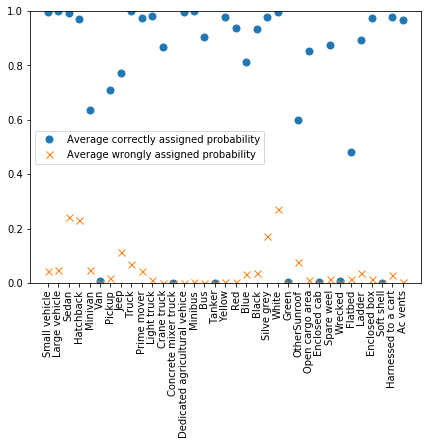

0.9502659709093616
0.03668913931332807


In [28]:
pos_acc , neg_acc = test_model()
print(pos_acc)
print(neg_acc)